# Iris Flower Train and Publish Model


In this notebook we will, 

1. Load the Iris Flower dataset into random split (train/test) DataFrames using a Feature View
2. Train a KNN Model using SkLearn
3. Evaluate model performance on the test set
4. Register the model with Hopsworks Model Registry

In [ ]:
!pip install -U hopsworks --quiet

In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import seaborn as sns
import hopsworks

/home/ucloud/miniconda3/envs/ucloud-sml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let's first get a feature_view for the iris flower dataset, or create one if it does not already exist.
If you are running this notebook for the first time, it will create the feature view, which contains all of the columns from the **iris feature group**.

There are 5 columns: 4 of them are "features", and the **variety** column is the **label** (what we are trying to predict using the 4 feature values in the label's row). The label is often called the **target**.

In [2]:
project = hopsworks.login()
fs = project.get_feature_store()

try: 
    feature_view = fs.get_feature_view(name="iris_test_roman", version=1)
except:
    iris_fg = fs.get_feature_group(name="iris_test_roman", version=1)
    query = iris_fg.select_all()
    feature_view = fs.create_feature_view(name="iris_test_roman",
                                      version=1,
                                      description="Read from Iris flower dataset",
                                      labels=["variety"],
                                      query=query)

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/327831
Connected. Call `.close()` to terminate connection gracefully.
Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/327831/fs/326726/fv/iris_test_roman/version/1


We will read our features and labels split into a **train_set** and a **test_set**. You split your data into a train_set and a test_set, because you want to train your model on only the train_set, and then evaluate its performance on data that was not seen during training, the test_set. This technique helps evaluate the ability of your model to accurately predict on data it has not seen before.

We can ask the feature_view to return a **train_test_split** and it returns:

* **X_** is a vector of features, so **X_train** is a vector of features from the **train_set**. 
* **y_** is a scale of labels, so **y_train** is a scalar of labels from the **train_set**. 

Note: a vector is an array of values and a scalar is a single value.

Note: that mathematical convention is that a vector is denoted by an uppercase letter (hence "X") and a scalar is denoted by a lowercase letter (hence "y").

**X_test** is the features and **y_test** is the labels from our holdout **test_set**. The **test_set** is used to evaluate model performance after the model has been trained.

In [3]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

Finished: Reading data from Hopsworks, using ArrowFlight (0.62s) 


In [4]:
y_train

,variety
0,Setosa
1,Versicolor
3,Versicolor
4,Setosa
5,Versicolor
...,...
142,Setosa
143,Setosa
145,Virginica
146,Virginica


Now, we can fit a model to our features and labels from our training set (**X_train** and **y_train**). 

Fitting a model to a dataset is more commonly called "training a model".

In [5]:
model = KNeighborsClassifier(n_neighbors=2)
model.fit(X_train, y_train.values.ravel())

KNeighborsClassifier(n_neighbors=2)

Now, we have trained our model. We can evaluate our model on the **test_set** to estimate its performance.

In [6]:
y_pred = model.predict(X_test)
y_pred

array(['Virginica', 'Setosa', 'Setosa', 'Virginica', 'Versicolor',
       'Virginica', 'Virginica', 'Versicolor', 'Virginica', 'Virginica',
       'Setosa', 'Versicolor', 'Versicolor', 'Setosa', 'Versicolor',
       'Virginica', 'Versicolor', 'Versicolor', 'Setosa', 'Setosa',
       'Virginica', 'Virginica', 'Versicolor', 'Versicolor', 'Virginica',
       'Virginica', 'Virginica', 'Versicolor', 'Versicolor', 'Virginica'],
      dtype=object)

We can report on how accurate these predictions (**y_pred**) are compared to the labels (the actual results - **y_test**). 

In [7]:
from sklearn.metrics import classification_report

metrics = classification_report(y_test, y_pred, output_dict=True)
print(metrics)

{'Setosa': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 6.0}, 'Versicolor': {'precision': 0.9090909090909091, 'recall': 1.0, 'f1-score': 0.9523809523809523, 'support': 10.0}, 'Virginica': {'precision': 1.0, 'recall': 0.9285714285714286, 'f1-score': 0.9629629629629629, 'support': 14.0}, 'accuracy': 0.9666666666666667, 'macro avg': {'precision': 0.9696969696969697, 'recall': 0.9761904761904763, 'f1-score': 0.9717813051146384, 'support': 30.0}, 'weighted avg': {'precision': 0.9696969696969696, 'recall': 0.9666666666666667, 'f1-score': 0.9668430335097002, 'support': 30.0}}


In [8]:
print(classification_report(y_test, y_pred, output_dict=False))

              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00         6
  Versicolor       0.91      1.00      0.95        10
   Virginica       1.00      0.93      0.96        14

    accuracy                           0.97        30
   macro avg       0.97      0.98      0.97        30
weighted avg       0.97      0.97      0.97        30



In [9]:
from sklearn.metrics import confusion_matrix

results = confusion_matrix(y_test, y_pred)
print(results)

[[ 6  0  0]
 [ 0 10  0]
 [ 0  1 13]]


Notice in the confusion matrix results that we have 1 or 2 incorrect predictions.
We have only 30 flowers in our test set - **y_test**.
Our model predicted 1 or 2 flowers were of type "Virginica", but the flowers were, in fact, "Versicolor".

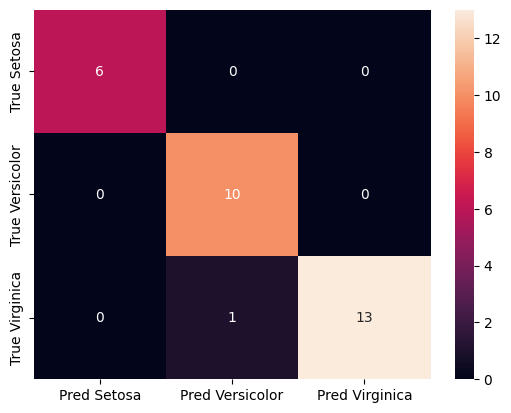

In [10]:
from matplotlib import pyplot

df_cm = pd.DataFrame(results, ['True Setosa', 'True Versicolor', 'True Virginica'],
                     ['Pred Setosa', 'Pred Versicolor', 'Pred Virginica'])

cm = sns.heatmap(df_cm, annot=True)

fig = cm.get_figure()
fig.savefig("assets/confusion_matrix.png") 
fig.show()

## Register the Model with Hopsworks Model Registry



In [11]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import os
import joblib
import hopsworks
import shutil

project =  hopsworks.login()
mr = project.get_model_registry()

# The 'iris_model' directory will be saved to the model registry
model_dir="iris_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)
joblib.dump(model, model_dir + "/iris_model.pkl")
shutil.copyfile("assets/confusion_matrix.png", model_dir + "/confusion_matrix.png")

input_example = X_train.sample()
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

iris_model = mr.python.create_model(
    version=1,
    name="iris_test_roman", 
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    input_example=input_example, 
    description="Iris Flower Predictor")

iris_model.save(model_dir)

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/327831
Connected. Call `.close()` to terminate connection gracefully.


Uploading: 100.000%|██████████| 11846/11846 elapsed<00:01 remaining<00:001,  3.24it/s]
Uploading: 100.000%|██████████| 18611/18611 elapsed<00:01 remaining<00:001,  3.24it/s]
Uploading: 100.000%|██████████| 20/20 elapsed<00:01 remaining<00:0003<00:08,  2.10s/it]
Uploading: 100.000%|██████████| 480/480 elapsed<00:01 remaining<00:00
Model export complete: 100%|██████████| 6/6 [00:13<00:00,  2.17s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/327831/models/iris_test_roman/1


Model(name: 'iris_test_roman', version: 1)